# Goals

To uncover the interplay between NER annotations and coref annotations. Specifically can finding NER directly lead to an estimation of num of clusters, do they all act as an antecedent?

# Specifics

1. Try to find num. mentions per coref cluster
2. Try to coalasce NER mentions (within one coref cluster) into one 'entity' and re-do this exp.
3. Try to do this coalasce thing globally within one document.

In [1]:
# Imports
import json
import numpy as np
import seaborn as sns
from pprint import pprint
from copy import deepcopy
from tqdm.auto import tqdm
from collections import Counter
from typing import List, Tuple, Dict, Union
from scipy.stats import norm

from config import LOCATIONS as LOC
from utils.misc import pop
from dataiter import RawCorefDataset

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

In [3]:
docs = {}
for i, doc in enumerate(RawCorefDataset('ontonotes', 'train', ignore_empty_coref=True)):
    docs[doc.docname] = doc

# Note: change the following block

1. from `spacy` to `gold` to look at gold NER annotations
2. from `...ner_some` to `...ner_all` to look at the case where we dont filter away NER annotations by a blacklist (ignoring cardinals etc).

In [4]:
entity_source = 'spacy' 
# entity_source = 'spacy'


# exp_name = f'{entity_source}ner_all.json'
exp_name = f'{entity_source}ner_some.json'

In [5]:
# Pull the summary from disk
with (LOC.runs / 'ne_coref' / exp_name).open('r', encoding='utf8') as f:
    summary = json.load(f)

# Plotting Time

In [6]:
def plot_avec_gauss(data: list, bins=None, xlabel: str= None, ylabel: str = None, plot_gauss: bool = True):
    """ 
        Assumes data is a list of integers 
        If not, it would create a key and "encode" every element with an integer.
    """
    
    sns.set_theme()
    
    
    vocab = {}
    freq = Counter(data)
    if type(data[0]) is not int:

        # We can also sort these things by the freq with which they appear
        freq = Counter(data)

        freq = dict(sorted(freq.items(), key=lambda kv: - kv[1]))
        vocab = {k: i for i, k in enumerate(freq.keys())}
        data = deepcopy(data)

        for i, datum in enumerate(data):
            data[i] = vocab[datum]


    bins = bins if bins else max(data)

    #     fig = plt.figure(figsize=(6,4))
    #     fig.set_dpi(150.0)
    #     plt.hist(data, bins=bins, density=True, alpha=0.6, color='b') #, x='Clusters in One Document', y='Frequency')

    fig = plt.figure(figsize=(6,4))
    fig.set_dpi(150.0)

    ax = fig.add_subplot(111, label="Hist")
    ax2 = fig.add_subplot(111, label="Mean", frame_on=False)
    ax.hist(data, bins=bins)


    if plot_gauss:
        mean, std = norm.fit(data)
        xmin, xmax = 0, max(data)
        x = np.linspace(xmin, xmax, bins*5)
        p = norm.pdf(x, mean, std)

        ax2.plot(x, p, 'k', linewidth=1)
        ax2.set_xticks([])
        ax2.set_yticks([])

    if xlabel:
        ax.set_xlabel(xlabel)

    if ylabel:
        ax.set_ylabel(ylabel)

    ax.tick_params(axis='x')
    ax.tick_params(axis='y')

    if vocab:
        plt.xticks(ticks=range(len(vocab)), labels=vocab.keys(), rotation=90, fontsize=8, color='green')


    plt.show()

    
def plot_avec_mean(data: list, bins=None, xlabel: str= None, ylabel: str = None, 
                   plot_mean: bool = True, plot_max: bool = True, xlog: bool = False, ylog: bool = False, 
                  ignore_outliers: int = 0, tickall_x: bool = False):
    vocab = {}

    sns.set_style("white")

    freq = Counter(data)
    if type(data[0]) is not int:

        # We can also sort these things by the freq with which they appear
        freq = Counter(data)

        freq = dict(sorted(freq.items(), key=lambda kv: - kv[1]))
        vocab = {k: i for i, k in enumerate(freq.keys())}
        data = deepcopy(data)

        for i, datum in enumerate(data):
            data[i] = vocab[datum]

            
    if ignore_outliers:
        data = deepcopy(data)
        mean = np.mean(data)
        std = np.std(data)
        popids = [i for i, val in enumerate(data) 
                  if not (mean - ignore_outliers*std) <= val <= (mean + ignore_outliers*std)]
        pop(data, popids)

    bins = bins if bins else max(data)

    fig = plt.figure(figsize=(6,4))
    fig.set_dpi(150.0)

    ax = fig.add_subplot(111, label="Hist")
    ax.hist(data, bins=bins)

    if plot_mean:
        mean = np.mean(data)
        ax.axvline(mean, color = 'r', linestyle = 'dashed', linewidth = 1)

    if plot_max:
        maxx = np.max(data)
        ax.axvline(maxx, color = 'teal', linestyle = 'dashed', linewidth = 1)
        
    if xlabel:
        ax.set_xlabel(xlabel)

    if ylabel:
        ax.set_ylabel(ylabel)

    if vocab:
        plt.xticks(ticks=range(len(vocab)), labels=vocab.keys(), rotation=90, fontsize=8, color='green')

    if xlog and not vocab:
        ax.set_xscale('log')
    #     ax.set_xticks([2, 4, 6, 10, 20, 50, 100])

    if ylog and not vocab:
        ax.set_yscale('log')
        
    if ylog and tickall_x:
        plt.xticks(ticks=range(0, max(data), int(np.std(data))), labels=range(0, max(data), int(np.std(data))))

    plt.grid(True, which="both", ls="-")
    plt.show()
    
    
def plot_dist(data: list, bins=None, xlabel: str= None, ylabel: str = None, log: bool = False):
    vocab = {}
    
    sns.set_theme()
    sns.set_style("whitegrid")
    
    freq = Counter(data)
    freq = dict(sorted(freq.items(), key=lambda kv: - kv[1]))
    
    if log:
        log_freqv = np.log(list(freq.values()))
        freq = {k:v for k, v in zip(freq.keys(), log_freqv)}
    
    fig = plt.figure(figsize=(6,4))
    fig.set_dpi(150.0)

    ax = fig.add_subplot(111, label="Hist")
    plt.xticks(ticks=range(len(freq)), labels=freq.keys(), rotation=90, fontsize=8, color='green' )
    ax.bar(range(len(freq)), freq.values())

    if log:
        ax.set_yscale('log')
    
    if xlabel:
        ax.set_xlabel(xlabel)

    if ylabel:
        ax.set_ylabel(ylabel)

    plt.show()
    

# Token Length Distribution
Are the documents of similar sizes? How varied are they?

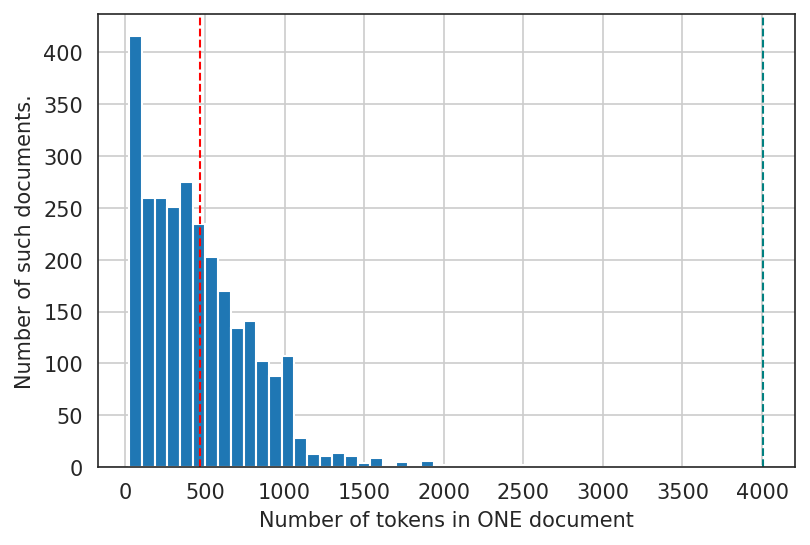

In [7]:
plot_avec_mean(summary['tokens_per_doc'], bins=50,
    xlabel="Number of tokens in ONE document",
    ylabel="Number of such documents.")

# Coref Span Length Distribution
What does the average length of a coref span look like. Is it long tailed?

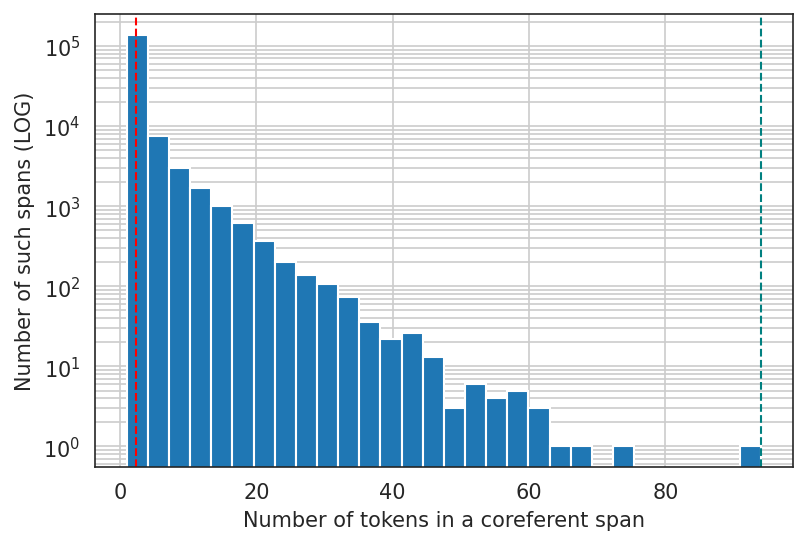

In [8]:
plot_avec_mean(summary['length_coref_per_span'], bins=30,
    xlabel="Number of tokens in a coreferent span",
    ylabel="Number of such spans (LOG)", ylog=True, tickall_x = False)

# Named Entity Span Length Distribution

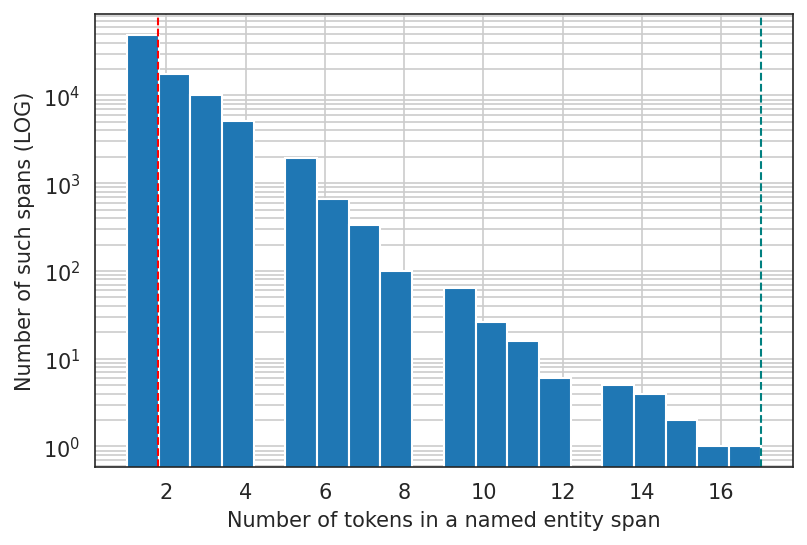

In [9]:
plot_avec_mean(summary['length_ner_per_span'], bins=20, ylog=True, tickall_x = False,
    xlabel="Number of tokens in a named entity span",
    ylabel="Number of such spans (LOG)")

# Coref Cluster Cardinality
Here, you can see the number of elements contained in coref clusters. 

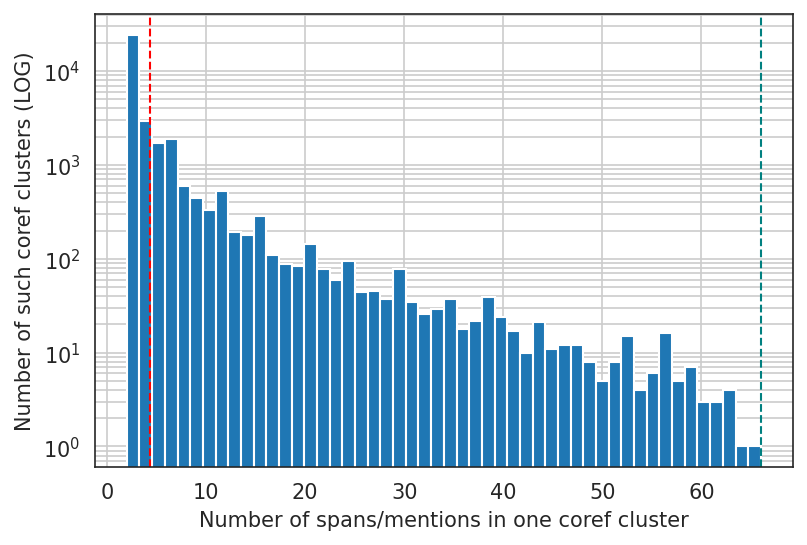

In [10]:
plot_avec_mean(summary['elements_per_cluster'],
              xlabel="Number of spans/mentions in one coref cluster",
              ylabel="Number of such coref clusters (LOG)", bins=50, ylog=True, ignore_outliers=10, plot_mean=True)

# Coref Cluster Distribution
In the first plot, we a distribution of number of coreference clusters in a document. This should give us an idea of how long tailed the distribution is, and how much memory do we aim to allocate per document.

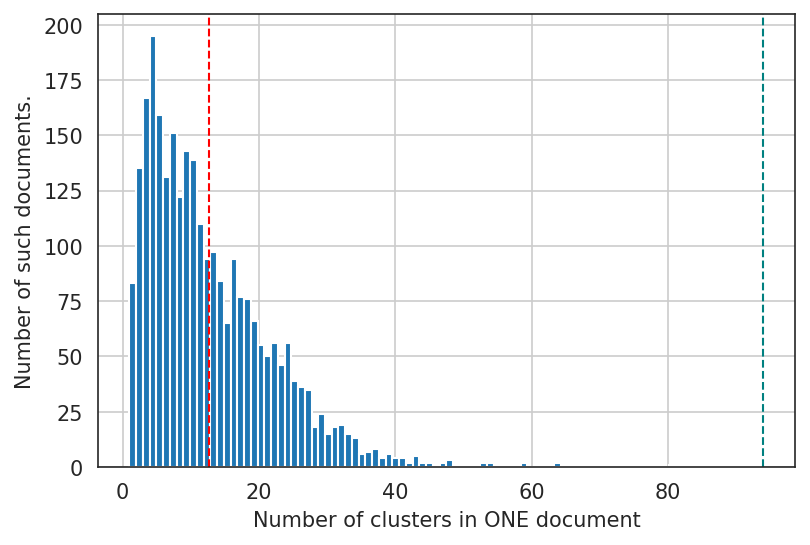

In [11]:
plot_avec_mean(summary['clusters_per_doc'],
    xlabel="Number of clusters in ONE document",
    ylabel="Number of such documents.")

# Named Entity Distribution
Here, we do a similar plot denoting the number of named entities found in a plot. Obviously, this serves little purpose except to illustrate the general distribution of entities.

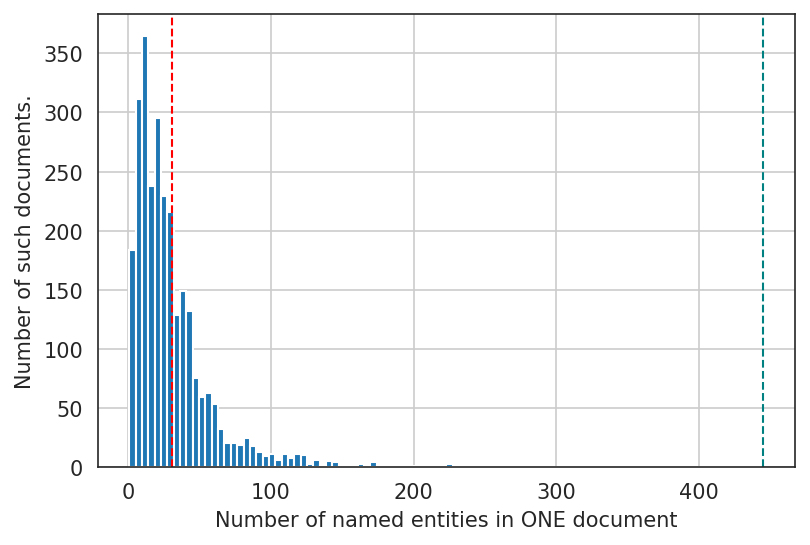

In [12]:
plot_avec_mean(summary['named_entities_per_doc'], bins=100,
    xlabel="Number of named entities in ONE document",
    ylabel="Number of such documents.")

# Named Entity Distribution by Tags
Which kind of named entities appear most often. 

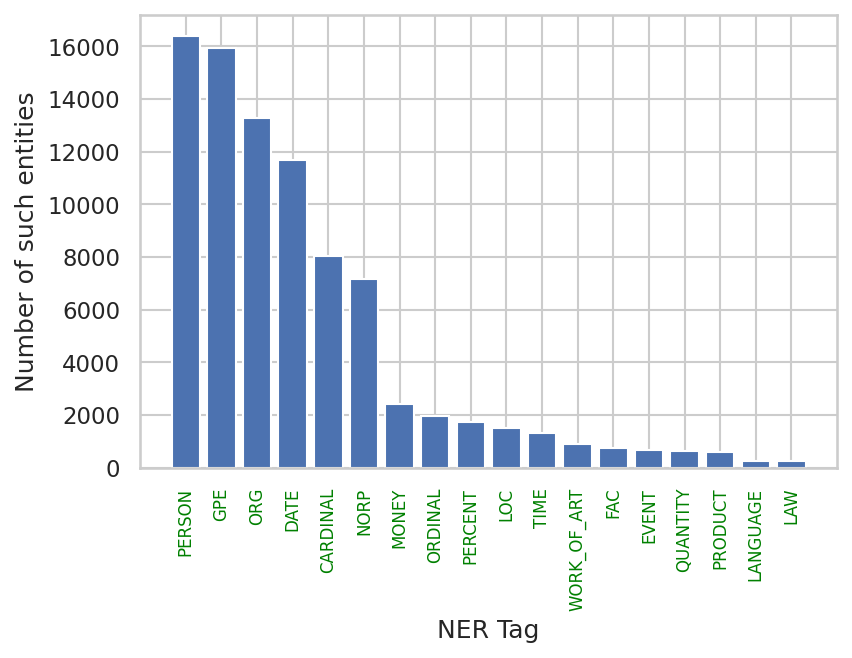

In [13]:
plot_dist(summary['named_entities_per_tag'],
    xlabel="NER Tag",
    ylabel="Number of such entities", log=False)

# Named Entity Distribution (clustered or not)
The same plot as above, except the clustered and unclustered variants of each kind of entities are plain to see.

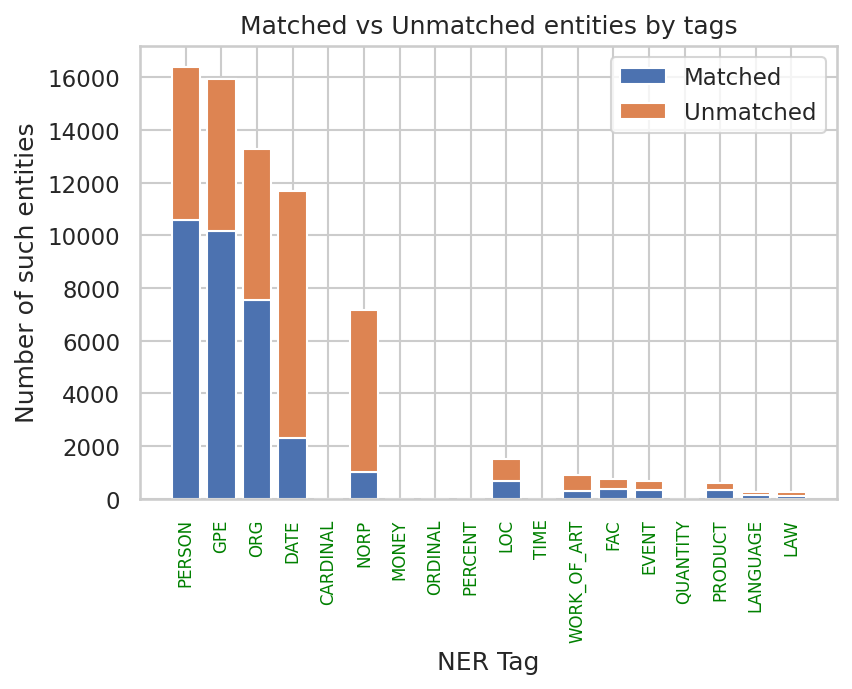

In [14]:
if True:
    unmatched_tags = Counter(summary['named_entities_unmatched_per_tag'])
    matched_tags = Counter(summary['named_entities_matched_per_tag'])
    total_tags = Counter(summary['named_entities_per_tag'])
    sorted_total_tags = dict(sorted(total_tags.items(), key=lambda kv: - kv[1]))
    sorted_unmatched_tags = {k: unmatched_tags[k] for k in sorted_total_tags.keys()}
    sorted_matched_tags = {k: matched_tags[k] for k in sorted_total_tags.keys()}
    # sorted_matched_tags = {k: v1-v2 for k, v1, v2 in zip(sorted_total_tags.keys(), sorted_total_tags.values(), sorted_unmatched_tags.values())}
    # sorted_unmatched_tags, sorted_matched_tags

    sns.set_theme()
    sns.set_style("whitegrid")

    fig = plt.figure(figsize=(6,4))
    fig.set_dpi(150.0)

    ax = fig.add_subplot(111, label="Hist")

    ax.bar(range(len(sorted_matched_tags)), sorted_matched_tags.values(), label="Matched")
    ax.bar(range(len(sorted_matched_tags)), sorted_unmatched_tags.values(), label="Unmatched", bottom=list(sorted_matched_tags.values()))
    ax.set_title("Matched vs Unmatched entities by tags")
    ax.legend()

    plt.xticks(ticks=range(len(sorted_matched_tags)), labels=sorted_matched_tags.keys(), rotation=90, fontsize=8, color='green' )

    ax.set_xlabel("NER Tag")
    ax.set_ylabel("Number of such entities")

# Relevant Numbers

In [15]:
if True:
    # Number of clusters with no entities
    total_clusters = np.sum(summary['clusters_per_doc'])
    unmatched_clusters = np.sum(summary['clusters_unmatched_per_doc'])
    matched_entities_per_cluster = np.mean([v for v in summary['named_entities_matched_per_cluster'] if v != 0])
    std = np.std([v for v in summary['named_entities_matched_per_cluster'] if v != 0])
    total_mismatched_clusters = np.sum(summary['clusters_matched_different_tags_per_doc'])


    print(f"Total Clusters in Train Set: {total_clusters}")
    print(f"Clusters with no NER matched: {unmatched_clusters}, "
          f"i.e. {100*unmatched_clusters / total_clusters:.1f} %.")

    print(f"However, amongst the one which have at least one NER entity matched, " 
          f"on average a cluster has {matched_entities_per_cluster:.2f} +- {std:.2f} entities")
    print(f"Finally, number of clusters which has entities containing "
          f"more than one tags: {total_mismatched_clusters}")

Total Clusters in Train Set: 34830
Clusters with no NER matched: 23104, i.e. 66.3 %.
However, amongst the one which have at least one NER entity matched, on average a cluster has 2.89 +- 2.79 entities
Finally, number of clusters which has entities containing more than one tags: 632


# Qualitative: Clusters with no Entities

----

#### wb/eng/00/eng_0013_0

###### Non prop. noun based clusters: 
... He makes **even the weirdest of the weird** feel normal . But unlike **them** , Jackson does n\'t try ...

###### Weird, overlapping clusters

... Like **children who are incapable of dissimulating <span style="color:green"><u>their</u></span> basic wants and needs** , Michael \'s manner of being in the world is ...


... , which tells the story of **a boy who refuses to grow up , who , through <span style="color:green"><u>his</u></span> drumming , rejects the adult world and the horrors taking place in Nazi Germany** . Like Oskar , Michael had witnessed firsthand the abominations of adult behaviour ...

----

#### wb/eng/00/eng_0003_1

###### Ungrounded clusters (okay maybe kind of grounded) but contains multiple voices i.e. both I and You
- `[20]`: **<u>EMR</u>** TMT said '' In Virginia , it \'s to benefit private business plans
- `[49]`: **<u>I</u>** do n\'t see the point of this statement because it 
- `[75]`: **<u>I</u>** think they are so tightly intertwined that they are virtually one and the same
- `[125]`: **<u>I</u>** do n\'t see there is any point in claiming as '' a solution '' 
- `[238]`: use out of our investment: we need more places in order to get closer to the balance **<u>you</u>** say we need

###### Non prop. noun based clusters
... where they own property and the incompetent system that funds **these requests** without regard to **their** link or lack thereof ...

###### More ungrounded (?) clusters
... **Many people** have legitimate preferences - horses , hunting , gardening , certain types of small business - that makes **them** NOT want to live in an urban core . ...

----

#### wb/eng/00/eng_0007_3

###### More examples of non-person clusters

We should evaluate **the expenditure** for what **it** does do and who benefits and assign the costs accordingly , if **the expenditure** is still reasonable . Clearly , that does ...

**Making** Route 7 sixteen lanes is probably just as bad an idea as Metro . **That** is just another plan ...


###### Ungrounded clusters that seem almost impossible to find (spread throughout the document)

- `[100]`: **<u>I</u>** \'d say that most people have made the connection 
- `[250]`: arguments accordingly . As for conservation easements , do n\'t get **<u>me</u>** started . When hundreds of organizations are founded
- `[880]`: **<u>I</u>** pointed out in another post the problems of planned communities .
- `[985]`: 'It seems to **<u>me</u>** that this exposes a critical weakness in what we psychologically view as fair .'
- `[1000]`: **<u>I</u>** would agree with Larry if : a ) existing ...

# Qualitative: Entities which do not belong to clusters

Some of them seem to **actual singletons**, some seem to be dates. Dates are weird. Some are coreferent. Many (~60%) are not. 

Example of unmatched entities

```
  [['GPE', 'Hollywood'], 
  ['DATE', 'the', 'age', 'of', '5'], 
  ['DATE', '11', '-', 'year', '-', 'olds'], 
  ['DATE', '11', '-', 'year', '-', 'old'], 
  ['DATE', 'the', 'past', '20', 'years'], 
  ['DATE', '1991'], ['DATE', 'June', '13', ',', '2005'], 
  ['PERSON', 'Mahatma', 'Gandhi'], 
  ['DATE', '11', '-', 'year', '-', 'old'], 
  ['FAC', 'Neverland'], 
  ['PERSON', 'Tennessee', 'Williams']]
```

# Ungrounded Clusters 

i.e. clusters with no proper noun in them.
This is a rough script which might catch many outliers and might not catch many actually ungrounded clusters.

In [16]:
len(docs), len(summary['ungrounded_clusters_per_doc'])

(2775, 2756)

In [17]:
i = np.random.choice(list(docs.keys()))
clusters = list(set(summary['ungrounded_clusters_per_doc'][i]))
print(i, clusters)
for cluster in clusters:
    print('------------')
    pprint(docs[i].clusters_[cluster])
    

mz/sinorama/10/ectb_1066_3 [4, 7]
------------
[['they'], ['them'], ['they'], ['hundred', '-', 'pacers'], ['they']]
------------
[['themselves'], ['they'], ['Their'], ['snakes'], ['their'], ['they']]


# Scratchpad